# Creating a Investment and Trading Web App
## Using PyTorch and SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

Now that we have a basic understanding of how SageMaker works we will try to use it to construct a complete project from end to end. Our goal will be to have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

For this project, you will be following the steps in the general outline with some modifications. 

First, you will not be testing the model in its own step. You will still be testing the model, however, you will do it by deploying your model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that you can make sure that your deployed model is working correctly before moving forward.

In addition, you will deploy and use your trained model a second time. In the second iteration you will customize the way that your trained model is deployed by including some of your own code. In addition, your newly deployed model will be used in the sentiment analysis web app.

## Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [214]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn.preprocessing

In [215]:
pd.options.display.float_format = '{:,.2f}'.format

In [216]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Downloading the data

As in the XGBoost in SageMaker notebook, we will be using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [217]:
!wget https://investment-and-trading-udacity.s3-us-west-2.amazonaws.com/JPM+2009-2019.csv -O ../data/raw/JPM+2009-2019.csv

--2019-08-03 02:49:57--  https://investment-and-trading-udacity.s3-us-west-2.amazonaws.com/JPM+2009-2019.csv
Resolving investment-and-trading-udacity.s3-us-west-2.amazonaws.com (investment-and-trading-udacity.s3-us-west-2.amazonaws.com)... 52.218.200.225
Connecting to investment-and-trading-udacity.s3-us-west-2.amazonaws.com (investment-and-trading-udacity.s3-us-west-2.amazonaws.com)|52.218.200.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187676 (183K) [text/csv]
Saving to: ‘../data/raw/JPM+2009-2019.csv’

../data/raw/JPM+200 100%[===================>] 183.28K   854KB/s    in 0.2s    

2019-08-03 02:49:58 (854 KB/s) - ‘../data/raw/JPM+2009-2019.csv’ saved [187676/187676]



In [218]:
stock_data = pd.read_csv('../data/raw/JPM+2009-2019.csv') 

In [219]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2654 entries, 0 to 2653
Data columns (total 7 columns):
Date         2654 non-null object
Open         2654 non-null float64
High         2654 non-null float64
Low          2654 non-null float64
Close        2654 non-null float64
Adj Close    2654 non-null float64
Volume       2654 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 145.2+ KB


In [220]:
stock_data.shape

(2654, 7)

In [221]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800


In [222]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,"2,654.00","2,654.00","2,654.00","2,654.00","2,654.00","2,654.00"
mean,62.13,62.72,61.53,62.13,55.72,"26,770,442.20"
std,25.80,25.91,25.69,25.79,27.44,"21,861,503.66"
min,15.37,17.29,14.96,15.90,12.46,"3,680,000.00"
25%,41.50,41.94,41.03,41.53,33.33,"13,436,550.00"
50%,56.62,57.00,56.14,56.67,49.27,"19,304,750.00"
75%,78.75,79.44,78.30,79.25,73.62,"32,481,600.00"
max,119.13,119.33,118.08,118.77,115.30,"217,294,200.00"


In [223]:
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Step 2: Data Exploration and Visualization

In [224]:
stock_data = stock_data.sort_values('Date')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800


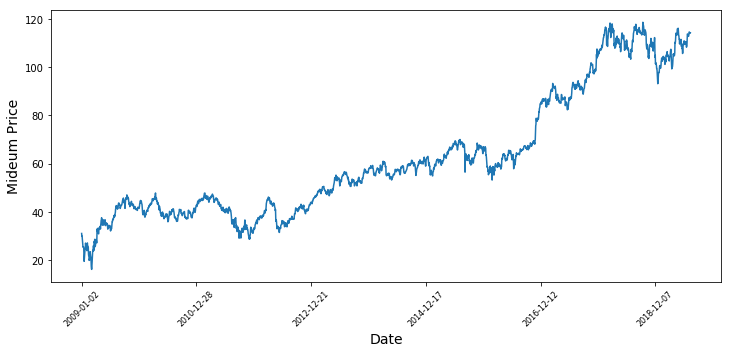

In [225]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data.shape[0]), (stock_data['Low'] + stock_data['High']) / 2.0)
plt.xticks(range(0, stock_data.shape[0], 500), stock_data['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

## Step 3: Preparing and splitting the data

Also, as in the XGBoost notebook, we will be doing some initial data processing. The first few steps are the same as in the XGBoost example. To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

In [317]:
# Index for train, validation and test
train_pct = 0.70
val_pct = 0.20
test_pct = 1 - train_pct - val_pct

print(int(train_pct * stock_data.shape[0]))
print(int(val_pct * stock_data.shape[0]))
print(int(test_pct * stock_data.shape[0]))



min_train_idx, max_train_idx = 0, int(stock_data.shape[0] * train_pct)
min_val_idx, max_val_idx = max_train_idx + 1, max_train_idx + int(stock_data.shape[0] * val_pct)
min_test_idx, max_test_idx = max_val_idx + 1,  stock_data.shape[0] 

1857
530
265


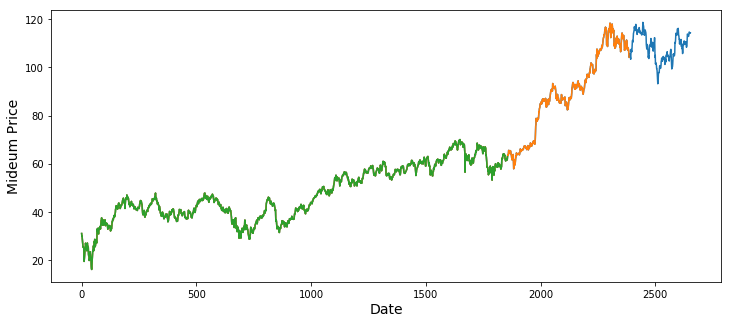

In [227]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data[min_train_idx:max_test_idx].shape[0]), (stock_data['Low'][min_train_idx:max_test_idx] + stock_data['High'][min_train_idx:max_test_idx]) / 2.0)
plt.plot(range(stock_data[min_train_idx:max_val_idx].shape[0]), (stock_data['Low'][min_train_idx:max_val_idx] + stock_data['High'][min_train_idx:max_val_idx]) / 2.0)
plt.plot(range(stock_data[min_train_idx:max_train_idx].shape[0]), (stock_data['Low'][min_train_idx:max_train_idx] + stock_data['High'][min_train_idx:max_train_idx]) / 2.0)
#plt.xticks(range(0, stock_data.shape[0], 500), stock_data['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

In [254]:
def normalize_data(df, input_list, target):
    '''Min-Max Scaler normalization function'''
    temp = df.copy()
    for feat in input_list:
        min_max_scaler = sklearn.preprocessing.MinMaxScaler()
        temp[feat] = min_max_scaler.fit_transform(temp[feat].values.reshape(-1,1))
        if feat == target:
            print('Saving Scaler Parameters...')
            scaler = min_max_scaler
    return temp, scaler

In [255]:
stock_data_normalized, scaler = normalize_data(stock_data, input_list = ['Open','High','Low','Close', 'Adj Close'], target = 'Close')

Saving Scaler Parameters...


In [256]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800


In [257]:
stock_data_normalized.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,0.15,0.14,0.15,0.15,0.12,32494900
1,2009-01-05,0.15,0.13,0.14,0.13,0.10,44069400
2,2009-01-06,0.14,0.13,0.14,0.14,0.11,44216300
3,2009-01-07,0.13,0.12,0.13,0.12,0.09,42156500
4,2009-01-08,0.12,0.10,0.12,0.11,0.09,52075800


In [262]:
stock_data['Close'].values.reshape(-1,1)

array([[ 31.35    ],
       [ 29.25    ],
       [ 29.879999],
       ...,
       [113.989998],
       [114.669998],
       [113.540001]])

In [263]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [264]:
scaler.inverse_transform(stock_data_normalized['Close'].values.reshape(-1,1))

array([[ 31.35    ],
       [ 29.25    ],
       [ 29.879999],
       ...,
       [113.989998],
       [114.669998],
       [113.540001]])

In [265]:
def create_sequences(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    '''Create sequence based on a specified len'''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets        

In [266]:
stock_data_normalized.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,0.15,0.14,0.15,0.15,0.12,32494900
1,2009-01-05,0.15,0.13,0.14,0.13,0.10,44069400
2,2009-01-06,0.14,0.13,0.14,0.14,0.11,44216300
3,2009-01-07,0.13,0.12,0.13,0.12,0.09,42156500
4,2009-01-08,0.12,0.10,0.12,0.11,0.09,52075800


In [267]:
def conver_to_array(df, list_features, target):
    '''Convert a dataframe into a numpy array to train the model'''
    temp = df[target + list_features]
    float_data = temp.as_matrix()
    return float_data

In [268]:
float_data = conver_to_array(stock_data_normalized, list_features = ['Open'], target = ['Close'])
print(float_data)

[[0.15018956 0.15246725]
 [0.12977545 0.14803393]
 [0.13589967 0.13897457]
 ...
 [0.95353359 0.95470319]
 [0.96014388 0.94988438]
 [0.94915917 0.95913649]]


In [86]:
lookback = 15
step = 1
delay = 2
batch_size = 16
train_gen = create_sequences(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 2000, shuffle = False, step = step, batch_size = batch_size)
val_gen = create_sequences(float_data, lookback = lookback, delay = delay, min_index = 2001, max_index = 2300, shuffle = False, step = step, batch_size = 1)

val_steps = stock_data.shape[0] - 2000 - lookback
print(val_steps)

639


In [87]:
samples, targets = next(train_gen)
print(samples.shape)
print(samples[:3])

(16, 15, 2)
[[[0.15018956 0.15246725]
  [0.12977545 0.14803393]
  [0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.10765229]
  [0.06726937 0.09117194]
  [0.02128901 0.05425983]
  [0.06542237 0.0377795 ]
  [0.06999125 0.06736701]
  [0.08146205 0.06312645]]

 [[0.12977545 0.14803393]
  [0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.10765229]
  [0.06726937 0.09117194]
  [0.02128901 0.05425983]
  [0.06542237 0.0377795 ]
  [0.06999125 0.06736701]
  [0.08146205 0.06312645]
  [0.08360066 0.09281033]]

 [[0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.107652

In [88]:
print(targets[:2])

[0.11391674 0.1095798 ]


## Step 4: Computing the common-sense, non-machine learning baseline

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. We will be making use of the high level SageMaker API to do this which will make the resulting code a little easier to read at the cost of some flexibility.

To construct an estimator, the object which we wish to train, we need to provide the location of a container which contains the training code. Since we are using a built in algorithm this container is provided by Amazon. However, the full name of the container is a bit lengthy and depends on the region that we are operating in. Fortunately, SageMaker provides a useful utility method called `get_image_uri` that constructs the image name for us.

To use the `get_image_uri` method we need to provide it with our current region, which can be obtained from the session object, and the name of the algorithm we wish to use. In this notebook we will be using XGBoost however you could try another algorithm if you wish. The list of built in algorithms can be found in the list of [Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).



In [89]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return (np.mean(batch_maes))
    

mean_absolute_error = evaluate_naive_method()
print(mean_absolute_error)

0.013268706003804817


In [90]:
std = stock_data['Close'][:max_train_idx].std(axis = 0)
print(std)

11.241057429262618


In [91]:
mean_absolute_error * std

0.14915428620077165

In [92]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,31.19,31.64,30.47,31.35,24.56,32494900
1,2009-01-05,30.73,30.77,29.08,29.25,22.92,44069400
2,2009-01-06,29.79,30.42,29.51,29.88,23.41,44216300
3,2009-01-07,29.15,29.40,28.00,28.09,22.01,42156500
4,2009-01-08,27.90,27.95,26.86,27.22,21.33,52075800


In [93]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(8, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 24s 47ms/step - loss: 0.0435 - val_loss: 0.2505
Epoch 2/10
500/500 [==============================] - 19s 39ms/step - loss: 0.0367 - val_loss: 0.2868
Epoch 3/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0305 - val_loss: 0.2886
Epoch 4/10
500/500 [==============================] - 21s 43ms/step - loss: 0.0278 - val_loss: 0.2875
Epoch 5/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0260 - val_loss: 0.2511
Epoch 6/10
500/500 [==============================] - 20s 39ms/step - loss: 0.0240 - val_loss: 0.2495
Epoch 7/10
500/500 [==============================] - 19s 39ms/step - loss: 0.0224 - val_loss: 0.2222
Epoch 8/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0215 - val_loss: 0.1864
Epoch 9/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0201 - val_loss: 0.1896
Epoch 10/10
500/500 [==============================] - 20s 39ms/step - loss: 0.020

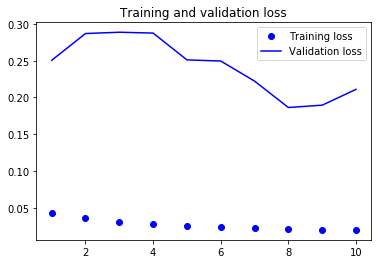

In [94]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [103]:
print(val_steps)
preds = model.predict_generator(val_gen, steps = 639)

639


In [124]:
x = next(val_gen)

In [125]:
x

(array([[[0.69709345, 0.7035467 ],
         [0.69116362, 0.69612568],
         [0.69174687, 0.69381267],
         [0.68630312, 0.6875482 ],
         [0.69116362, 0.68128373],
         [0.69213571, 0.6969931 ],
         [0.69116362, 0.69275253],
         [0.69213571, 0.69072863],
         [0.68873337, 0.69284892],
         [0.69534366, 0.68581343],
         [0.69271902, 0.69121047],
         [0.69038592, 0.68725908],
         [0.69446873, 0.69130686],
         [0.69709345, 0.69381267],
         [0.66462525, 0.69622208]]]), array([0.67280264]))

In [126]:
model.predict(x[0])

array([[0.49882084]], dtype=float32)

In [141]:
val_gen.send('restart')

(array([[[0.69116362, 0.68128373],
         [0.69213571, 0.6969931 ],
         [0.69116362, 0.69275253],
         [0.69213571, 0.69072863],
         [0.68873337, 0.69284892],
         [0.69534366, 0.68581343],
         [0.69271902, 0.69121047],
         [0.69038592, 0.68725908],
         [0.69446873, 0.69130686],
         [0.69709345, 0.69381267],
         [0.66462525, 0.69622208],
         [0.66161175, 0.66210488],
         [0.66958298, 0.66345413],
         [0.66880528, 0.67280264],
         [0.67910959, 0.66865846]]]), array([0.67212802]))

In [128]:
series = np.array([1,2,3,4,5,6,7,8,9,10])

In [130]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [131]:
n_inputs = 2
generator = TimeseriesGenerator(series, series, length = n_inputs, batch_size = 1)

In [132]:
# number of samples
print('Samples: %d' % len(generator))

Samples: 8


In [134]:
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))

[[1 2]] => [3]
[[2 3]] => [4]
[[3 4]] => [5]
[[4 5]] => [6]
[[5 6]] => [7]
[[6 7]] => [8]
[[7 8]] => [9]
[[8 9]] => [10]


In [318]:
n_inputs = 15
train_generator = TimeseriesGenerator(float_data, float_data[:,0], start_index = 0, end_index = max_train_idx, length = n_inputs, batch_size = 32, )
val_generator = TimeseriesGenerator(float_data, float_data[:,0], start_index = min_val_idx - n_inputs , end_index = max_val_idx, length = n_inputs, batch_size = 1)

In [174]:
float_data[:10]

array([[0.15018956, 0.15246725],
       [0.12977545, 0.14803393],
       [0.13589967, 0.13897457],
       [0.11849908, 0.13280648],
       [0.11004179, 0.12075945],
       [0.09789053, 0.11738627],
       [0.08758628, 0.10167695],
       [0.10158453, 0.09483423],
       [0.09730728, 0.09849653],
       [0.0820453 , 0.10765229]])

In [175]:
for i in range(len(train_generator)):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

[[[0.15018956 0.15246725]
  [0.12977545 0.14803393]
  [0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.10765229]
  [0.06726937 0.09117194]
  [0.02128901 0.05425983]
  [0.06542237 0.0377795 ]
  [0.06999125 0.06736701]
  [0.08146205 0.06312645]]

 [[0.12977545 0.14803393]
  [0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.10765229]
  [0.06726937 0.09117194]
  [0.02128901 0.05425983]
  [0.06542237 0.0377795 ]
  [0.06999125 0.06736701]
  [0.08146205 0.06312645]
  [0.08360066 0.09281033]]

 [[0.13589967 0.13897457]
  [0.11849908 0.13280648]
  [0.11004179 0.12075945]
  [0.09789053 0.11738627]
  [0.08758628 0.10167695]
  [0.10158453 0.09483423]
  [0.09730728 0.09849653]
  [0.0820453  0.10765229]
  [0.067

In [186]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.LSTM(32, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.1))


model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_generator,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=len(val_generator))

Epoch 1/10
500/500 [==============================] - 42s 83ms/step - loss: 0.0374 - val_loss: 0.1375
Epoch 2/10
500/500 [==============================] - 34s 68ms/step - loss: 0.0247 - val_loss: 0.0724
Epoch 3/10
500/500 [==============================] - 33s 66ms/step - loss: 0.0217 - val_loss: 0.0920
Epoch 4/10
500/500 [==============================] - 35s 69ms/step - loss: 0.0202 - val_loss: 0.0583
Epoch 5/10
500/500 [==============================] - 33s 67ms/step - loss: 0.0185 - val_loss: 0.0898
Epoch 6/10
500/500 [==============================] - 33s 65ms/step - loss: 0.0180 - val_loss: 0.0791
Epoch 7/10
500/500 [==============================] - 32s 65ms/step - loss: 0.0171 - val_loss: 0.0781
Epoch 8/10
500/500 [==============================] - 35s 69ms/step - loss: 0.0166 - val_loss: 0.0523
Epoch 9/10
500/500 [==============================] - 37s 74ms/step - loss: 0.0158 - val_loss: 0.1023
Epoch 10/10
500/500 [==============================] - 34s 68ms/step - loss: 0.015

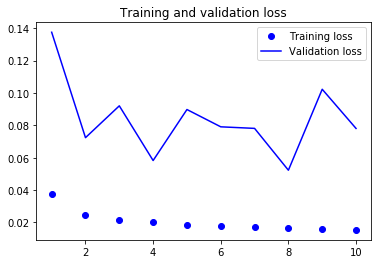

In [187]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [188]:
for i in range(len(val_generator)):
    x, y = val_generator[i]
    print('%s => %s' % (x, y))

[[[0.46281714 0.46732847]
  [0.4623311  0.46337705]
  [0.47282981 0.46809946]
  [0.48235636 0.47773712]
  [0.47759308 0.4838088 ]
  [0.4814815  0.48033925]
  [0.47992611 0.48535085]
  [0.48400898 0.47600235]
  [0.48517546 0.48332689]
  [0.47380189 0.47108714]
  [0.48002333 0.4748458 ]
  [0.4778847  0.48265226]
  [0.47973171 0.47764072]
  [0.47487121 0.47629147]
  [0.46602509 0.4680031 ]]] => [0.46048412]
[[[0.4623311  0.46337705]
  [0.47282981 0.46809946]
  [0.48235636 0.47773712]
  [0.47759308 0.4838088 ]
  [0.4814815  0.48033925]
  [0.47992611 0.48535085]
  [0.48400898 0.47600235]
  [0.48517546 0.48332689]
  [0.47380189 0.47108714]
  [0.48002333 0.4748458 ]
  [0.4778847  0.48265226]
  [0.47973171 0.47764072]
  [0.47487121 0.47629147]
  [0.46602509 0.4680031 ]
  [0.46048412 0.46366617]]] => [0.44891614]
[[[0.47282981 0.46809946]
  [0.48235636 0.47773712]
  [0.47759308 0.4838088 ]
  [0.4814815  0.48033925]
  [0.47992611 0.48535085]
  [0.48400898 0.47600235]
  [0.48517546 0.48332689]
  

In [319]:
predictions = model.predict_generator(val_generator)

In [321]:
len(predictions)

530

In [322]:
for i in range(len(val_generator)):
    _, y = val_generator[i]
    print(y)

[0.46281714]
[0.4623311]
[0.47282981]
[0.48235636]
[0.47759308]
[0.4814815]
[0.47992611]
[0.48400898]
[0.48517546]
[0.47380189]
[0.48002333]
[0.4778847]
[0.47973171]
[0.47487121]
[0.46602509]
[0.46048412]
[0.44891614]
[0.44784682]
[0.45027707]
[0.45086031]
[0.4517352]
[0.45737341]
[0.45504035]
[0.46806653]
[0.424808]
[0.40546323]
[0.42403034]
[0.44036164]
[0.44949937]
[0.44094488]
[0.42432196]
[0.43054341]
[0.43433463]
[0.44648589]
[0.45076311]
[0.45980366]
[0.45941481]
[0.46874701]
[0.46933024]
[0.4671916]
[0.46621952]
[0.46689998]
[0.46456693]
[0.4679693]
[0.46631671]
[0.46884416]
[0.47078841]
[0.46855254]
[0.46728883]
[0.46563624]
[0.46417812]
[0.47399636]
[0.4730242]
[0.4899388]
[0.48799455]
[0.48575877]
[0.48002333]
[0.48177312]
[0.48041218]
[0.4843006]
[0.48420337]
[0.48595315]
[0.48653639]
[0.48566154]
[0.4850783]
[0.48478661]
[0.48653639]
[0.48770294]
[0.4891611]
[0.4962574]
[0.50160398]
[0.50160398]
[0.49878488]
[0.50150675]
[0.50102074]
[0.49829888]
[0.49917373]
[0.49334114]


In [323]:
print(len(val_generator))

530


In [324]:
predictions[:10]

array([[0.41844964],
       [0.42173404],
       [0.42225862],
       [0.4256726 ],
       [0.43200207],
       [0.4355799 ],
       [0.4374587 ],
       [0.43876755],
       [0.4389227 ],
       [0.44057035]], dtype=float32)

In [325]:
for i in range(len(val_generator)):
    _, y = val_generator[i]
    print(y)

[0.46281714]
[0.4623311]
[0.47282981]
[0.48235636]
[0.47759308]
[0.4814815]
[0.47992611]
[0.48400898]
[0.48517546]
[0.47380189]
[0.48002333]
[0.4778847]
[0.47973171]
[0.47487121]
[0.46602509]
[0.46048412]
[0.44891614]
[0.44784682]
[0.45027707]
[0.45086031]
[0.4517352]
[0.45737341]
[0.45504035]
[0.46806653]
[0.424808]
[0.40546323]
[0.42403034]
[0.44036164]
[0.44949937]
[0.44094488]
[0.42432196]
[0.43054341]
[0.43433463]
[0.44648589]
[0.45076311]
[0.45980366]
[0.45941481]
[0.46874701]
[0.46933024]
[0.4671916]
[0.46621952]
[0.46689998]
[0.46456693]
[0.4679693]
[0.46631671]
[0.46884416]
[0.47078841]
[0.46855254]
[0.46728883]
[0.46563624]
[0.46417812]
[0.47399636]
[0.4730242]
[0.4899388]
[0.48799455]
[0.48575877]
[0.48002333]
[0.48177312]
[0.48041218]
[0.4843006]
[0.48420337]
[0.48595315]
[0.48653639]
[0.48566154]
[0.4850783]
[0.48478661]
[0.48653639]
[0.48770294]
[0.4891611]
[0.4962574]
[0.50160398]
[0.50160398]
[0.49878488]
[0.50150675]
[0.50102074]
[0.49829888]
[0.49917373]
[0.49334114]


In [326]:
closing_price = scaler.inverse_transform(predictions)

In [327]:
closing_price[:10]

array([[58.945915],
       [59.28378 ],
       [59.33774 ],
       [59.68894 ],
       [60.340054],
       [60.708103],
       [60.901375],
       [61.03602 ],
       [61.05198 ],
       [61.22147 ]], dtype=float32)

In [328]:
float_data[min_train_idx: max_train_idx][:,0]

array([0.15018956, 0.12977545, 0.13589967, ..., 0.4448333 , 0.4448333 ,
       0.4679693 ])

In [329]:
closing_price_squeeze = closing_price.squeeze()

In [330]:
stock_data['Close'].shape

(2654,)

In [331]:
closing_price_squeeze.shape

(530,)

In [332]:
results = np.concatenate((stock_data['Close'][:max_train_idx], closing_price_squeeze, stock_data['Close'][max_val_idx:max_test_idx]))

In [333]:
stock_data['Close'][:max_train_idx].shape

(1857,)

In [334]:
stock_data['Close'][max_val_idx:max_test_idx].shape

(267,)

In [335]:
results.shape

(2654,)

In [336]:
stock_data.shape[0]

2654

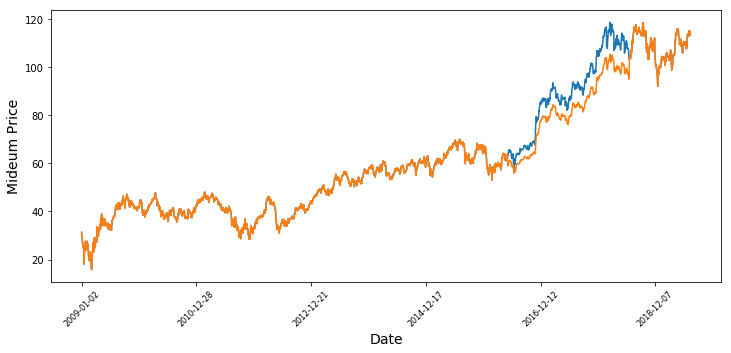

In [337]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data.shape[0]), (stock_data['Close']))
plt.plot(range(stock_data.shape[0]), (results))
plt.xticks(range(0, stock_data.shape[0], 500), stock_data['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()